In [2]:
import numpy as np
import time
import sys
from copy import deepcopy
import tensorflow as tf
# from tensorflow.python.ops.seq2seq import sequence_loss
from tensorflow.contrib.seq2seq import sequence_loss
import matplotlib.pyplot as plt

In [3]:
from collections import defaultdict

import numpy as np

class Vocab(object):
    def __init__(self):
        self.word_to_index = {}
        self.index_to_word = {}
        self.word_freq = defaultdict(int)
        self.total_words = 0
        self.unknown = '<unk>'
        self.add_word(self.unknown, count=0)

    def add_word(self, word, count=1):
        if word not in self.word_to_index:
            index = len(self.word_to_index)
            self.word_to_index[word] = index
            self.index_to_word[index] = word
        self.word_freq[word] += count

    def construct(self, words):
        for word in words:
            self.add_word(word)
        self.total_words = float(sum(self.word_freq.values()))
        print '{} total words with {} uniques'.format(self.total_words, len(self.word_freq))

    def encode(self, word):
        if word not in self.word_to_index:
            word = self.unknown
        return self.word_to_index[word]

    def decode(self, index):
        return self.index_to_word[index]

    def __len__(self):
        return len(self.word_freq)

def calculate_perplexity(log_probs):
    # https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf
    perp = 0
    for p in log_probs:
        perp += -p
    return np.exp(perp / len(log_probs))

def get_ptb_dataset(dataset='train'):
    fn = 'data/ptb/ptb.{}.txt'
    for line in open(fn.format(dataset)):
        for word in line.split():
            yield word
    # Add token to the end of the line
    # Equivalent to <eos> in:
    # https://github.com/wojzaremba/lstm/blob/master/data.lua#L32
    # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py#L31
        yield '<eos>'

def ptb_iterator(raw_data, batch_size, num_steps):
    # Pulled from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py#L82
    raw_data = np.array(raw_data, dtype=np.int32)
    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]
    epoch_size = (batch_len - 1) // num_steps
    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")
    for i in range(epoch_size):
        x = data[:, i * num_steps:(i + 1) * num_steps]
        y = data[:, i * num_steps + 1:(i + 1) * num_steps + 1]
        yield (x, y)

def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    # from https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))

def data_iterator(orig_X, orig_y=None, batch_size=32, label_size=2, shuffle=False):
    # Optionally shuffle the data before training
    if shuffle:
        indices = np.random.permutation(len(orig_X))
        data_X = orig_X[indices]
        data_y = orig_y[indices] if np.any(orig_y) else None
    else:
        data_X = orig_X
        data_y = orig_y
    ###
    total_processed_examples = 0
    total_steps = int(np.ceil(len(data_X) / float(batch_size)))
    for step in xrange(total_steps):
        # Create the batch by selecting up to batch_size elements
        batch_start = step * batch_size
        x = data_X[batch_start:batch_start + batch_size]
        # Convert our target from the class index to a one hot vector
        y = None
        if np.any(data_y):
            y_indices = data_y[batch_start:batch_start + batch_size]
            y = np.zeros((len(x), label_size), dtype=np.int32)
            y[np.arange(len(y_indices)), y_indices] = 1
        ###
        yield x, y
        total_processed_examples += len(x)
    # Sanity check to make sure we iterated over all the dataset as intended
    assert total_processed_examples == len(data_X), 'Expected {} and processed {}'.format(len(data_X), total_processed_examples)


In [4]:
# Model Parameters
np.random.seed(8)
batch_size_train = 64
embed_size = 50
hidden_size = 100
num_steps = 1 # 10
max_epochs = 20 # 16
early_stopping = 2
dropout = 0.9
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.001
lr = tf.train.exponential_decay(starter_learning_rate, global_step, 10000, 0.98, staircase=True) # 0.0001 # 0.001

In [5]:
# Load Data - Loads starter word-vectors and train/dev/test data.
# Set debug To True while Debugging
debug  = False # True

vocab = Vocab()
vocab.construct(get_ptb_dataset('train'))
encoded_train = np.array(
    [vocab.encode(word) for word in get_ptb_dataset('train')],
    dtype=np.int32)
encoded_valid = np.array(
    [vocab.encode(word) for word in get_ptb_dataset('valid')],
    dtype=np.int32)
encoded_test = np.array(
    [vocab.encode(word) for word in get_ptb_dataset('test')],
    dtype=np.int32)
if debug:
    num_debug = 1024
    encoded_train = encoded_train[:num_debug]
    encoded_valid = encoded_valid[:num_debug]
    encoded_test = encoded_test[:num_debug]

929589.0 total words with 10000 uniques


In [6]:
# Generate placeholder variables to represent the input tensors
input_placeholder   = tf.placeholder(dtype = tf.int32,shape = (None, num_steps) )
labels_placeholder  = tf.placeholder(dtype = tf.int32,shape = (None, num_steps) ) 
dropout_placeholder = tf.placeholder(dtype = tf.float32)

In [7]:
# Add embedding layer
with tf.device('/cpu:0'):
    vocabulary_size = len(vocab)
    embedding_matrix = tf.Variable(  tf.random_uniform([vocabulary_size, embed_size],-1.0,1.0)  )
    word_embeddings = tf.nn.embedding_lookup(embedding_matrix, input_placeholder)
    inputs = [tf.squeeze(seq) for seq in tf.split(word_embeddings,num_steps,axis = 1)]  
    

In [8]:
# Create the RNN LM model
rnn_states = []
rnn_outputs = []
inputs = [tf.nn.dropout(i,dropout_placeholder) for i in inputs] 

np.random.seed(8)
inititalizer = tf.random_normal_initializer()

with tf.variable_scope('RNN-LM'):
    np.random.seed(8)
    batch_size = tf.Variable(batch_size_train,dtype = tf.int32,validate_shape=False)# tf.shape(inputs[0])[0]
    # initial_state = tf.Variable( tf.zeros((batch_size, hidden_size),tf.float32))# ,validate_shape=False)
    initial_state = tf.zeros((batch_size, hidden_size),tf.float32)
    H = tf.get_variable('H',(hidden_size, hidden_size),tf.float32,inititalizer)
    I = tf.get_variable('I',(embed_size, hidden_size),tf.float32,inititalizer)
    b_1 = tf.get_variable('b_1',(hidden_size,),tf.float32,inititalizer)
    U = tf.get_variable('U',(hidden_size, len(vocab)),tf.float32,inititalizer)
    b_2 = tf.get_variable('b_2',(len(vocab),),tf.float32,inititalizer)
    curr_state = initial_state

with tf.variable_scope('RNN-LM') as scope:
    scope.reuse_variables()
    H = tf.get_variable('H',None,tf.float32)
    I = tf.get_variable('I',None,tf.float32)
    b_1 = tf.get_variable('b_1',None,tf.float32)
    U = tf.get_variable('U',None,tf.float32)
    b_2 = tf.get_variable('b_2',None,tf.float32)
    for i in xrange(num_steps):
        curr_state = tf.nn.sigmoid(tf.matmul(curr_state,H) + tf.matmul(inputs[i],I) + b_1)
        pred = tf.nn.softmax( tf.matmul(curr_state,U) + b_2 )
        # put the states and output_predictions in a list
        rnn_states.append(curr_state)
        rnn_outputs.append(pred)
        final_state = curr_state
    # Define loss function
    output = tf.convert_to_tensor(rnn_outputs)
    seq_weight = tf.ones((num_steps,batch_size))
    calc_loss = sequence_loss(output,labels_placeholder,seq_weight)

In [9]:
predictions = [tf.nn.softmax(tf.cast(o, 'float64')) for o in rnn_outputs]

In [10]:
# train_op = tf.train.GradientDescentOptimizer(self.config.lr).minimize(loss)
train_op = tf.train.AdamOptimizer(lr).minimize(calc_loss)

In [11]:
def run_epoch(session, data, train_op=None, verbose=10):
    dp = dropout
    if not train_op:
        train_op = tf.no_op()
        dp = 1
    total_steps = sum(1 for x in ptb_iterator(data, batch_size_train, num_steps))
    total_loss = []
    state = session.run(initial_state,feed_dict = {batch_size : batch_size_train})
    for step, (x, y) in enumerate(
        ptb_iterator(data, batch_size_train, num_steps)):
        # We need to pass in the initial state and retrieve the final state to give
        # the RNN proper history
        feed = {input_placeholder: x,
              labels_placeholder: y,
              initial_state: state,
              dropout_placeholder: dp}
        loss, state, _ = session.run([calc_loss, final_state, train_op], feed_dict=feed)
        total_loss.append(loss)
        if verbose and step % verbose == 0:
            sys.stdout.write('\r{} / {} : pp = {}'.format(step, total_steps, np.exp(np.mean(total_loss))))
            sys.stdout.flush()
    if verbose:
        sys.stdout.write('\r')
    return np.exp(np.mean(total_loss))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0
Training perplexity: 9454.81738281
Validation perplexity: 9388.48046875
Total time: 1219.62410903


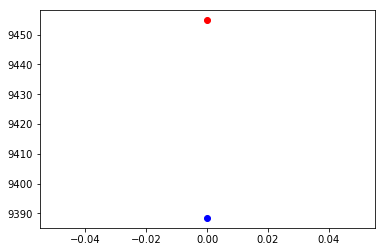

Epoch 1
Training perplexity: 9247.46582031
Validation perplexity: 9155.4765625
Total time: 1187.78512287


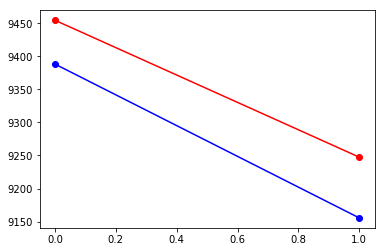

Epoch 2
Training perplexity: 9143.35644531
Validation perplexity: 9132.02832031
Total time: 1200.19509697


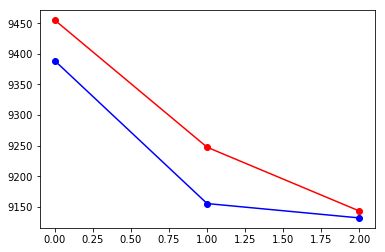

Epoch 3
Training perplexity: 9120.02636719
Validation perplexity: 9122.79199219
Total time: 1196.11955094


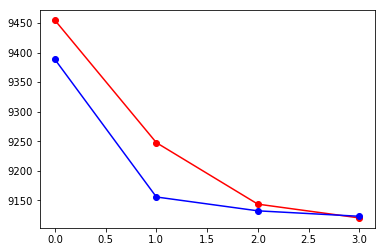

Epoch 4
Training perplexity: 9110.37695312
Validation perplexity: 9123.5234375
Total time: 1193.31824994


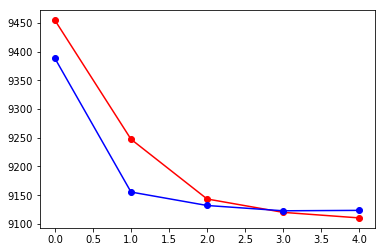

Epoch 5
Training perplexity: 9104.56640625
Validation perplexity: 9112.84472656
Total time: 1200.44447899


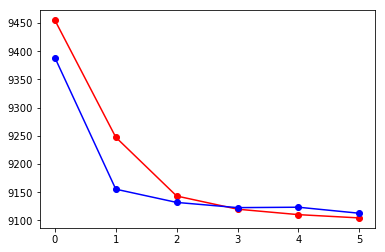

Epoch 6
Training perplexity: 9097.87402344
Validation perplexity: 9113.23632812
Total time: 1204.73200893


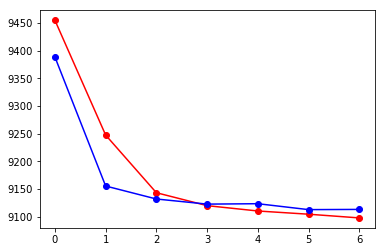

Epoch 7
Training perplexity: 9093.37207031
Validation perplexity: 9110.203125
Total time: 1198.76455283


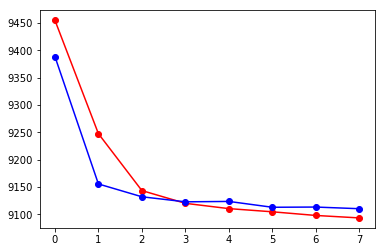

Epoch 8
Training perplexity: 9086.15136719
Validation perplexity: 9083.68261719
Total time: 1238.32303715


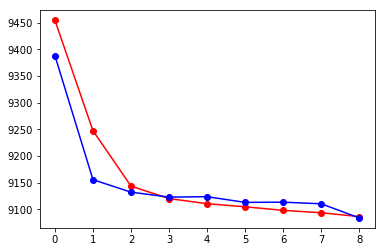

Epoch 9
Training perplexity: 9042.14355469
Validation perplexity: 9054.578125
Total time: 1384.74499393


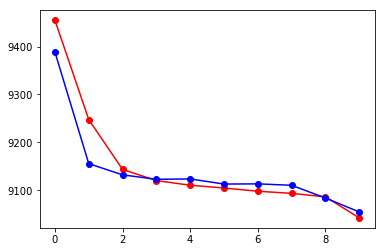

Epoch 10
Training perplexity: 9018.57226562
Validation perplexity: 9042.24707031
Total time: 1281.25719905


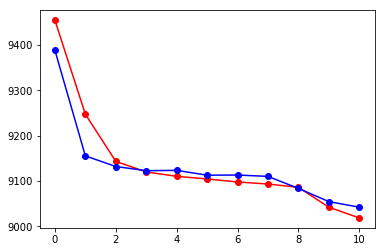

Epoch 11
Training perplexity: 9007.95703125
Validation perplexity: 9043.17871094
Total time: 1233.86810207


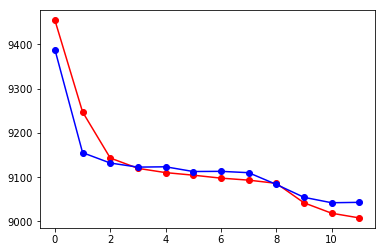

Epoch 12
Training perplexity: 9001.76562581
Validation perplexity: 9031.23339844
Total time: 1310.85210896


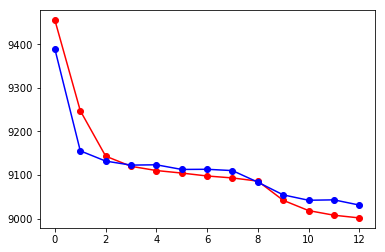

Epoch 13
Training perplexity: 8997.94628906
Validation perplexity: 9034.46386719
Total time: 1351.7348361


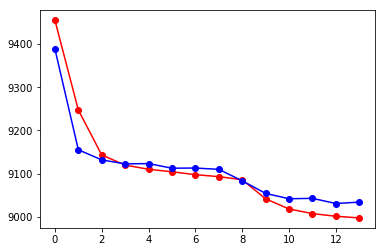

Epoch 14
Training perplexity: 8993.27050781
Validation perplexity: 9035.23046875
Total time: 1313.81246305


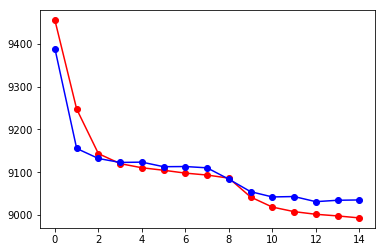

Epoch 15
Training perplexity: 8989.53125159
Validation perplexity: 9035.99707031
INFO:tensorflow:Restoring parameters from ptb_rnnlm.weights-anneal
=-==-==-==-==-=p = 9040.62597656
Test perplexity: 9040.64355469
=-==-==-==-==-=


In [12]:
# Train the Model

tpp_list, vpp_list =  [], []

init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as session:
    best_val_pp = float('inf')
    best_val_epoch = 0
    
    np.random.seed(8)
    session.run(init)
    for epoch in xrange(max_epochs):
        print 'Epoch {}'.format(epoch)
        start = time.time()
        ###
        train_pp = run_epoch(session, encoded_train, train_op)
        valid_pp = run_epoch(session, encoded_valid)
        tpp_list.append(train_pp)
        vpp_list.append(valid_pp)
        print 'Training perplexity: {}'.format(train_pp)
        print 'Validation perplexity: {}'.format(valid_pp)
        if valid_pp < best_val_pp:
            best_val_pp = valid_pp
            best_val_epoch = epoch
            saver.save(session, './ptb_rnnlm.weights-anneal')
        if epoch - best_val_epoch > early_stopping:
            break
        print 'Total time: {}'.format(time.time() - start)
        plt.plot(range(len(tpp_list)),tpp_list,'ro',linestyle = '-')
        plt.plot(range(len(tpp_list)),vpp_list,'bo',linestyle = '-')
        plt.show()
        ###
    saver.restore(session, 'ptb_rnnlm.weights-anneal')
    test_pp = run_epoch(session, encoded_test)
    print '=-=' * 5
    print 'Test perplexity: {}'.format(test_pp)
    print '=-=' * 5
        

In [16]:
# Make functions to generate text from Model
def generate_text(session, starting_text='<eos>',stop_length=20, stop_tokens=None, temp=1.0):
    # Imagine tokens as a batch size of one, length of len(tokens[0])
    tokens = [vocab.encode(word) for word in starting_text.split()]
    # session.run(batch_size,feed_dict={input_placeholder:tokens})
    # state = initial_state.eval()
    
    for i in xrange(stop_length):
        ### YOUR CODE HERE
        state = session.run(initial_state,feed_dict={batch_size:len(tokens)})
        # print tokens
        feed = {input_placeholder: np.array(tokens).reshape((len(tokens),1)),
                initial_state: state,
                dropout_placeholder: dropout
               }
        y_pred = session.run(predictions[-1], feed_dict = feed)
        state = session.run(curr_state, feed_dict = feed)
        # print session.run([curr_state,predictions[-1]], feed_dict = feed)
        ### END YOUR CODE
        next_word_idx = sample(y_pred[0], temperature=temp)
        tokens.append(next_word_idx)
        batch_size.assign(len(tokens))
        if stop_tokens and vocab.decode(tokens[-1]) in stop_tokens:
            break
    output = [vocab.decode(word_idx) for word_idx in tokens]
    return output

def generate_sentence(session, *args, **kwargs):
    """Convenice to generate a sentence from the model."""
    return generate_text(session, *args, stop_tokens=['<eos>'], **kwargs)

In [ ]:
# Generate some Text
with tf.Session() as session:
    saver.restore(session, 'ptb_rnnlm.weights-anneal')
    starting_text = 'in palo alto'
    while starting_text:
        print ' '.join(generate_sentence(session, starting_text=starting_text, temp=1.0))
        starting_text = raw_input('> ')

INFO:tensorflow:Restoring parameters from ptb_rnnlm.weights-anneal
in palo alto kronor department-store external worthy procedure resistance pretax please onerous helm teller recruited angeles-based combining weakness aimed chunk tony petroleum yen
> hey there
<unk> there train succeed suspended softness rowe christmas fanfare bar crash commute important ordinarily esselte siemens patience trap regulators gorky transit board
> the best pizza i had was in dominos . 
the best pizza i had was in <unk> <unk> respond specifically blues rica picking avondale smiling reduce multimillion-dollar chunk reasons fleets planning faced walked schwab wachter demise properly boyer
> water water
water water photograph skiers long-awaited break geneva proposition walking markey loyal trucking pointing blood king stick lawrence olympics heating donald slow embarrassing
